# Estimation of a binary probit model

by [Manuel V. Montesinos](https://manuelmontesinos.com/), September 2025

This notebook estimates the parameters of a binary probit model explaining whether a car is foreign based on its weight and mileage, using data from http://www.stata-press.com/data/r13/auto. The model is 

$$\Pr(\text{foreign} = 1) = \Phi(\beta_0 + \beta_1*\text{weight} + \beta_2*\text{mpg}).$$

The estimates delivered by Stata:
```stata
probit foreign mpg weight

Iteration 0:  Log likelihood =  -45.03321  
Iteration 1:  Log likelihood = -27.914626  
Iteration 2:  Log likelihood = -26.858074  
Iteration 3:  Log likelihood = -26.844197  
Iteration 4:  Log likelihood = -26.844189  
Iteration 5:  Log likelihood = -26.844189  

Probit regression                                       Number of obs =     74
                                                        LR chi2(2)    =  36.38
                                                        Prob > chi2   = 0.0000
Log likelihood = -26.844189                             Pseudo R2     = 0.4039

------------------------------------------------------------------------------
     foreign | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
         mpg |  -.1039503   .0515689    -2.02   0.044    -.2050235   -.0028772
      weight |  -.0023355   .0005661    -4.13   0.000     -.003445   -.0012261
       _cons |   8.275464   2.554142     3.24   0.001     3.269437    13.28149
------------------------------------------------------------------------------
```

Let's try to replicate these estimates with different algorithms in Python:

In [19]:
# Import modules
import numpy as np
import pandas as pd
import estimagic as em
import matplotlib.pyplot as plt
from bprobit_llike import bprobit_llike
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# Set seed
np.random.seed(13)

# Start
print('')
print('ESTIMATION OF A BINARY PROBIT MODEL')
print('')

#-------------------------------------------------------------------------------

# Import the data using a dataframe
auto = pd.read_csv('auto.csv')

# Organize the data and add a constant
choice = auto['foreign'].to_numpy()
mpg = auto['mpg'].to_numpy()
weight = auto['weight'].to_numpy()
constant = np.ones(len(choice))
regressors = np.column_stack((mpg, weight, constant))

#-------------------------------------------------------------------------------

# Initial values of the parameter vector
b0 = np.zeros(3)

# Estimate the model using the Nelder-Mead algorithm (gradient-free)
print('Estimate the model using the Nelder-Mead algorithm')
history = {'Nfeval': 0, 'nfeval': [], 'fval': [], 'params': []}
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
outmin = minimize(bprobit_llike, b0, args=(choice, regressors, history), \
    method='nelder-mead', options={'xatol': 1e-5, 'disp': True, 'return_all': False})

print('')
print('Parameter estimates using SciPy Nelder-Mead algorithm: ')
print('mpg:    ', outmin.x[0])
print('weight: ', outmin.x[1])
print('cons:   ', outmin.x[2])
print('')
print('-----------------------------------------------------------------------')
print('')


ESTIMATION OF A BINARY PROBIT MODEL

Estimate the model using the Nelder-Mead algorithm
Iter   f(X)     
   0    51.292891
  10    43.024160
  20    40.142341
  30    39.900743
  40    38.667266
  50    34.496567
  60    33.310734
  70    32.969833
  80    32.990334
  90    32.963101
 100    32.961633
 110    32.961445
 120    32.961200
 130    32.960303
 140    32.952439
 150    32.908288
 160    32.628975
 170    31.736619
 180    31.355381
 190    28.640826
 200    26.928198
 210    26.858339
 220    26.847722
 230    26.847070
 240    26.844503
 250    26.844192
 260    26.844190
 270    26.844189
 280    26.844189
 290    26.844189
 300    26.844189
 310    26.844189
 320    26.844189
Optimization terminated successfully.
         Current function value: 26.844189
         Iterations: 181
         Function evaluations: 323

Parameter estimates using SciPy Nelder-Mead algorithm: 
mpg:     -0.10395031372345426
weight:  -0.002335545213352719
cons:    8.275464735744446

-------------

In [20]:
# Estimate the model using Nelder-Mead's estimagic. Install estimagic by following  
# these instructions: https://estimagic.org/en/latest/getting_started/installation.html
print('Estimate the model using Nelder-Mead estimagic')
history = {'Nfeval': 0, 'nfeval': [], 'fval': [], 'params': []}
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
outmin_em = em.minimize(
    criterion=bprobit_llike,
    params=np.zeros(3),
    algorithm="scipy_neldermead",
    criterion_kwargs={"yobs": choice, "xobs": regressors, "info": history}
)

print('')
print('Estimation results using estimagic Nelder-Mead algorithm: ', outmin_em)
print('')
print('Parameter estimates using estimagic Nelder-Mead algorithm: ', outmin_em.params)
print('')
print('-----------------------------------------------------------------------')
print('')

Estimate the model using Nelder-Mead estimagic
Iter   f(X)     
   0    51.292891
  10    41.855185
  20    40.380938
  30    39.965205
  40    38.976206
  50    34.966768
  60    33.740262
  70    33.189329
  80    32.968231
  90    32.961833
 100    32.961453
 110    32.961517
 120    32.961269
 130    32.960335
 140    32.954695
 150    32.922238
 160    32.648213
 170    31.646382
 180    31.428286
 190    29.283386
 200    26.992613
 210    26.893035
 220    26.873469
 230    26.844824
 240    26.844234
 250    26.844271
 260    26.844195
 270    26.844189
 280    26.844189
 290    26.844189
 300    26.844189
 310    26.844189
 320    26.844189
 330    26.844189
 340    26.844189
 350    26.844189
 360    26.844189
 370    26.844189
 380    26.844189
 390    26.844189
 400    26.844189

Estimation results using estimagic Nelder-Mead algorithm:  Minimize with 3 free parameters terminated successfully after 403 criterion evaluations and 216 iterations.

The value of criterion improv

In [21]:
# Estimate the model using the differential evolution algorithm in SciPy
# (gradient-free). It does not perform well 
bounds_de = [(-1, 1), (-1, 1), (-10, 10)]
print('Estimate the model using the differential evolution algorithm in SciPy: ')
history = {'Nfeval': 0, 'nfeval': [], 'fval': [], 'params': []}
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
outmin_desp = optimize.differential_evolution(bprobit_llike, bounds_de, 
    args=(choice, regressors, history))

print('')
print('Parameter estimates using the differential evolution algorithm in SciPy: ')
print('mpg:    ', outmin_desp.x[0])
print('weight: ', outmin_desp.x[1])
print('cons:   ', outmin_desp.x[2])
print('')
print('-----------------------------------------------------------------------')
print('')

Estimate the model using the differential evolution algorithm in SciPy: 
Iter   f(X)     
   0    253.284880
  10    253.284880
  20    253.284880
  30    598.672344
  40    617.691652
  50    253.284880
  60    253.284880
  70    253.284880
  80    253.284880
  90    598.672344
 100    253.284880
 110    253.284880
 120    253.284880
 130    253.284880
 140    598.672344
 150    253.284880
 160    253.284880
 170    253.284880
 180    253.284880
 190    253.284880
 200    253.284880
 210    253.284880
 220    253.284880

Parameter estimates using the differential evolution algorithm in SciPy: 
mpg:     0.18927253265130295
weight:  -0.7920764133517253
cons:    1.6268559359998491

-----------------------------------------------------------------------



In [22]:
# Estimate the model using the differential evolution algorithm in estimagic.
# The algorithm does not perform well unless appropriate bounds are provided
info = np.iinfo(np.int64)
lower_bounds_de = np.array([-1, -1, -10]) 
upper_bounds_de = np.array([1, 1, 10])

# Trying with wider bounds, but it does not perform well
# lower_bounds_de = np.array([-1000, -1000, -1000]) 
# upper_bounds_de = np.array([1000, 1000, 1000])

print('Estimate the model using the differential evolution algorithm in estimagic: ')
history = {'Nfeval': 0, 'nfeval': [], 'fval': [], 'params': []}
outmin_em = em.minimize(
    criterion=bprobit_llike,
    params=np.zeros(3),
    algorithm="scipy_differential_evolution",
    criterion_kwargs={"yobs": choice, "xobs": regressors, "info": history},
    lower_bounds=lower_bounds_de,
    upper_bounds=upper_bounds_de
)

print('')
print('Estimation results using estimagic differential evolution algorithm: ', outmin_em)
print('Parameter estimates using estimagic differential evolution algorithm: ', outmin_em.params)
print('')
print('-----------------------------------------------------------------------')
print('')

Estimate the model using the differential evolution algorithm in estimagic: 
   0    51.292891
  10    253.284880
  20    598.672344
  30    598.672344
  40    253.284880
  50    253.284880
  60    4134.196004
  70    598.672344
  80    598.672344
  90    253.284880
 100    253.284880
 110    598.672344
 120    253.284880
 130    598.672344
 140    253.284880
 150    253.284880
 160    253.284880
 170    598.672344
 180    253.284880
 190    598.672344
 200    598.672344
 210    598.672344
 220    253.284880
 230    598.672344
 240    253.284880
 250    253.284880
 260    598.672344
 270    253.284880
 280    598.672344
 290    253.284880
 300    598.672344
 310    253.284880
 320    253.284880
 330    253.284880
 340    758.861748
 350    598.672344
 360    253.284880
 370    253.284880
 380    253.284880
 390    5231.370929
 400    598.672344
 410    253.284880
 420    253.284880
 430    598.672344
 440    253.284880
 450    253.284880
 460    253.284880
 470    253.284880
 480    25

Estimate the model using the Powell algorithm in SciPy: 
Iter   f(X)     
   0    51.292891
  10    47.992047
  20    598.672344
  30    473.851659
  40    57.963836
  50    4715.494939
  60    253.284880
  70    598.672344
  80    41.445960
  90    40.750947
 100    30.966246
 110    30.574847
 120    30.552859
 130    30.490409
 140    30.417117
 150    30.382920
 160    30.271122
 170    29.545515
 180    29.534893
 190    29.016281
 200    28.689115
 210    47.834145
 220    29.207195
 230    28.122760
 240    27.954516
 250    27.951618
 260    27.812722
 270    27.708049
 280    50.090472
 290    27.578082
 300    27.507126
 310    27.461876
 320    27.451497
 330    27.193758
 340    27.111919
 350    27.028470
 360    26.975811
 370    26.962663
 380    26.914078
 390    26.912023
 400    26.864642
 410    27.854609
 420    26.861283
 430    26.844196
Optimization terminated successfully.
         Current function value: 26.844195
         Iterations: 12
         Function evalu

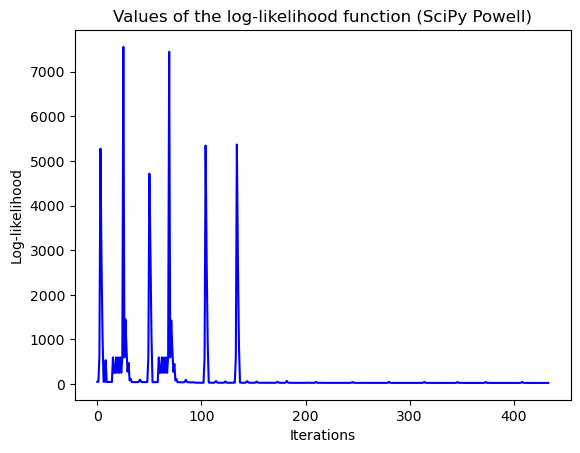


Parameter estimates using SciPy Powell algorithm: 
mpg:     -0.10408768278701803
weight:  -0.0023360216763085497
cons:    8.27974054015435

-----------------------------------------------------------------------



In [23]:
# Estimate the model using the Powell algorithm in SciPy (gradient-free). It 
# performs quite well and takes 434 function evaluations to converge (some more
# than Nelder-Mead)
print('Estimate the model using the Powell algorithm in SciPy: ')
history = {'Nfeval': 0, 'nfeval': [], 'fval': [], 'params': []}
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
outmin = minimize(bprobit_llike, b0, args=(choice, regressors, history), \
    method='Powell', options={'disp': True})

# Plot the values of the criterion function
plt.plot(history['nfeval'], history['fval'], linestyle='-', color='b')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')
plt.title('Values of the log-likelihood function (SciPy Powell)')
plt.show()

print('')
print('Parameter estimates using SciPy Powell algorithm: ')
print('mpg:    ', outmin.x[0])
print('weight: ', outmin.x[1])
print('cons:   ', outmin.x[2])
print('')
print('-----------------------------------------------------------------------')
print('')

In [24]:
# Estimate the model using the Powell algorithm in estimagic (gradient-free)
print('Estimate the model using the Powell algorithm in estimagic: ')
history = {'Nfeval': 0, 'nfeval': [], 'fval': [], 'params': []}
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
outmin_em = em.minimize(
    criterion=bprobit_llike,
    params=np.zeros(3),
    algorithm="scipy_powell",
    criterion_kwargs={"yobs": choice, "xobs": regressors, "info": history}
)

# Make a plot of the evolution of the criterion function
fig = em.criterion_plot(outmin_em)
fig.show()

# Make a plot of the evolution of the parameter estimates
fig = em.params_plot(outmin_em)
fig.show()

print('')
print('Estimation results using estimagic Powell algorithm: ', outmin_em)
print('Parameter estimates using estimagic Powell algorithm: ', outmin_em.params)
print('')
print('-----------------------------------------------------------------------')
print('')

Estimate the model using the Powell algorithm in estimagic: 
Iter   f(X)     
   0    51.292891
  10    47.991282
  20    598.672344
  30    805.226001
  40    44.961763
  50    44.044761
  60    43.634803
  70    253.284880
  80    79.227819
  90    55.144946
 100    40.747650
 110    30.995214
 120    30.573000
 130    30.551892
 140    30.484796
 150    30.410042
 160    30.376168
 170    30.369758
 180    29.691962
 190    29.578107
 200    29.075777
 210    28.706075
 220    28.544310
 230    29.936138
 240    28.476308
 250    28.191233
 260    28.036309
 270    28.012761
 280    27.870745
 290    27.762834
 300    27.697400
 310    27.663865
 320    27.627951
 330    27.557137
 340    48.861331
 350    27.404147
 360    27.221907
 370    27.107199
 380    27.057881
 390    27.004422
 400    26.971490
 410    26.932084
 420    26.917300
 430    26.849794
 440    49.303068
 450    27.142794
 460    26.947715
 470    33.340955
 480    26.955060
 490    26.887540
 500    26.844189
 


Estimation results using estimagic Powell algorithm:  Minimize with 3 free parameters terminated successfully after 590 criterion evaluations and 14 iterations.

The value of criterion improved from 51.29289136143595 to 26.844189005798686.

The scipy_powell algorithm reported: Optimization terminated successfully.

Independent of the convergence criteria used by scipy_powell, the strength of convergence can be assessed by the following criteria:

                             one_step     five_steps 
relative_criterion_change          0***  1.323e-16***
relative_params_change     2.754e-15***  3.359e-09** 
absolute_criterion_change          0***  3.553e-15***
absolute_params_change     8.886e-15***  1.641e-08*  

(***: change <= 1e-10, **: change <= 1e-8, *: change <= 1e-5. Change refers to a change between accepted steps. The first column only considers the last step. The second column considers the last five steps.)
Parameter estimates using estimagic Powell algorithm:  [-1.03950331e

In [25]:
# Estimate the model using a dual annealing algorithm. It does not perform 
# well unless appropriate bounds are provided. Given the same bounds, it does
# better than differential evolution, although it takes three times more
# iterations to converge

bounds_sa = [(-1, 1), (-1, 1), (-10, 10)]

# Trying with wider bounds, but it does not perform well
# bounds_sa = [(-1000, 1000), (-1000, 1000), (-1000, 1000)]

print('Estimate the model using the dual annealing algorithm in SciPy: ')
history = {'Nfeval': 0, 'nfeval': [], 'fval': [], 'params': []}
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
outmin_sa = optimize.dual_annealing(bprobit_llike, bounds_sa, 
    args=(choice, regressors, history))

print('')
print('Parameter estimates using a dual annealing algorithm: ')
print('mpg:    ', outmin_sa.x[0])
print('weight: ', outmin_sa.x[1])
print('cons:   ', outmin_sa.x[2])
print('')
print('-----------------------------------------------------------------------')
print('')

Estimate the model using the dual annealing algorithm in SciPy: 
Iter   f(X)     
   0    598.672344
  10    253.284880
  20    253.284880
  30    253.284880
  40    253.284880
  50    253.284880
  60    253.284880
  70    253.284880
  80    253.284880
  90    598.672344
 100    253.284880
 110    253.284880
 120    598.672344
 130    253.284880
 140    253.284880
 150    253.284880
 160    253.284880
 170    253.284880
 180    253.284880
 190    253.284880
 200    253.284880
 210    253.284880
 220    253.284880
 230    253.284880
 240    598.672344
 250    253.284880
 260    253.284880
 270    253.284880
 280    253.284880
 290    253.284880
 300    253.284880
 310    253.284880
 320    253.284880
 330    253.284880
 340    253.284880
 350    253.284880
 360    253.284880
 370    253.284880
 380    253.284880
 390    598.672344
 400    253.284880
 410    253.284880
 420    598.672344
 430    253.284880
 440    253.284880
 450    598.672344
 460    253.284880
 470    253.284880
 480  

Estimate the model using the L-BFGS-B algorithm in SciPy: 
Iter   f(X)     
   0    51.292891
  10    253.284880
  20    6754.533090
  30    40.143265
  40    40.141689
  50    40.134684
  60    39.996270
  70    39.199813
  80    34.091709
  90    32.953940
 100    32.944196
 110    32.944195
 120    32.944187
 130    32.944141
 140    32.943206
 150    32.937445
 160    32.823412
 170    32.163756
 180    33.635158
 190    27.822100
 200    26.844275
 210    26.844189
 220    26.844189


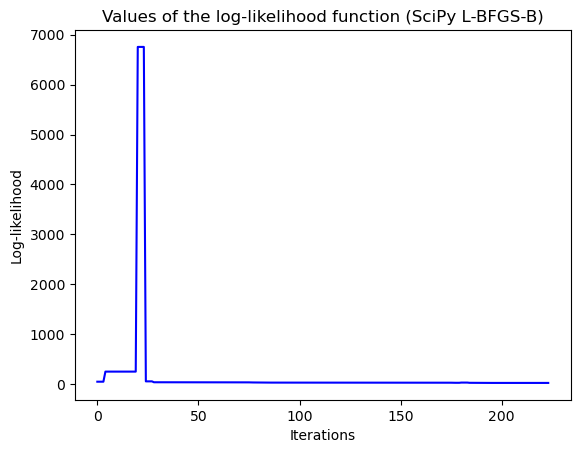


Parameter estimates using SciPy L-BFGS-B algorithm: 
mpg:     -0.10397147846399804
weight:  -0.0023358419227919123
cons:    8.276739311985597

-----------------------------------------------------------------------



In [26]:
# Estimate the model using the L-BFGS-B algorithm in SciPy
print('Estimate the model using the L-BFGS-B algorithm in SciPy: ')
history = {'Nfeval': 0, 'nfeval': [], 'fval': [], 'params': []}
print('{0:4s}   {1:9s}'.format('Iter', 'f(X)'))
outmin = minimize(bprobit_llike, b0, args=(choice, regressors, history), \
    method='L-BFGS-B', options={'disp': True})

# Plot the values of the criterion function
plt.plot(history['nfeval'], history['fval'], linestyle='-', color='b')
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')
plt.title('Values of the log-likelihood function (SciPy L-BFGS-B)')
plt.show()

print('')
print('Parameter estimates using SciPy L-BFGS-B algorithm: ')
print('mpg:    ', outmin.x[0])
print('weight: ', outmin.x[1])
print('cons:   ', outmin.x[2])
print('')
print('-----------------------------------------------------------------------')
print('')